In [ ]:
#LGM import
import os
import tyro
import imageio
import numpy as np
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from safetensors.torch import load_file
import cv2
import rembg
import gradio as gr
import argparse

import kiui
from kiui.op import recenter
from kiui.cam import orbit_camera

from core.options import AllConfigs, Options, config_defaults
from core.models import LGM
from mvdream.pipeline_mvdream import MVDreamPipeline

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

In [2]:
def load_images(args):
    input_dir = args.input_dir
    images = torch.zeros(21, 576, 576, 3).type(torch.float32).to(args.device)
    for i in range(21):
        idx = (args.istart + i) % 21
        image_path = os.path.join(input_dir, "{:04}.png".format(idx))
        image_np = cv2.imread(image_path)
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        image_np = np.array(image_np, dtype=np.float32) / 255.0
        images[idx] = torch.tensor(image_np)

    images = images.permute(0, 3, 1, 2)
    images = images.to(args.device)
    return images

In [3]:
class defaut_path:
    output_ply_path = 'pointclouds.ply'
    output_video_path = 'video.mp4'


class args:
    input_dir = './0000/images'
    istart = 0
    device = 'cuda:0'
    checkpoints_path = 'pretrained/model_fp16.safetensors'
    output_ply_path = './outputs/pointclouds.ply'
    output_video_path = './outputs/video.mp4'


args = args

In [4]:
opt = config_defaults['big']
opt.resume = args.checkpoints_path
opt.num_frames = 21

if args.output_ply_path is not None:
    defaut_path.output_ply_path = args.output_ply_path
if args.output_video_path is not None:
    defaut_path.output_video_path = args.output_video_path

In [5]:
model = LGM(opt)
# resume pretrained checkpoint
if opt.resume is not None:
    if opt.resume.endswith('safetensors'):
        ckpt = load_file(opt.resume, device='cpu')
    else:
        ckpt = torch.load(opt.resume, map_location='cpu')
    model.load_state_dict(ckpt, strict=False)
    print(f'[INFO] Loaded checkpoint from {opt.resume}')
else:
    print(f'[WARN] model randomly initialized, are you sure?')

model = model.half().to(args.device)
model.eval()

[INFO] Loaded checkpoint from pretrained/model_fp16.safetensors


LGM(
  (unet): UNet(
    (conv_in): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownBlock(
        (nets): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (shortcut): Identity()
          )
        )
        (attns): ModuleList(
          (0-1): 2 x None
        )
        (downsample): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (1): DownBlock(
        (nets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
            (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 12

In [6]:
tan_half_fov = np.tan(0.5 * np.deg2rad(opt.fovy))
proj_matrix = torch.zeros(4, 4, dtype=torch.float32, device=args.device)
proj_matrix[0, 0] = 1 / tan_half_fov
proj_matrix[1, 1] = 1 / tan_half_fov
proj_matrix[2, 2] = (opt.zfar + opt.znear) / (opt.zfar - opt.znear)
proj_matrix[3, 2] = - (opt.zfar * opt.znear) / (opt.zfar - opt.znear)
proj_matrix[2, 3] = 1

In [7]:
images = load_images(args)
print(f'[INFO] Loaded {len(images)} images')
input_image = F.interpolate(images, size=(opt.input_size, opt.input_size), mode='bilinear', align_corners=False)
input_image = TF.normalize(input_image, IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
rays_embeddings = model.prepare_default_rays(args.device, num_frames=opt.num_frames, elevation=10)
input_image = torch.cat([input_image, rays_embeddings], dim=1).unsqueeze(0)  # [1, 4, 9, H, W]

[INFO] Loaded 21 images


In [8]:
with torch.no_grad():
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        # generate gaussians
        gaussians = model.forward_gaussians(input_image)

    # save gaussians
    model.gs.save_ply(gaussians, defaut_path.output_ply_path)

In [9]:
model = model.to('cpu')
torch.cuda.empty_cache()
model = model.half().to(args.device)

In [10]:
# render 360 video
images = []
elevation = 0
if opt.fancy_video:
    azimuth = np.arange(0, 720, 4, dtype=np.int32)
    for azi in tqdm.tqdm(azimuth):
        cam_poses = torch.from_numpy(orbit_camera(elevation, azi, radius=opt.cam_radius, opengl=True)).unsqueeze(
            0).to(args.device)

        cam_poses[:, :3, 1:3] *= -1  # invert up & forward direction

        # cameras needed by gaussian rasterizer
        cam_view = torch.inverse(cam_poses).transpose(1, 2)  # [V, 4, 4]
        cam_view_proj = cam_view @ proj_matrix  # [V, 4, 4]
        cam_pos = - cam_poses[:, :3, 3]  # [V, 3]

        scale = min(azi / 360, 1)

        image = model.gs.render(gaussians, cam_view.unsqueeze(0), cam_view_proj.unsqueeze(0), cam_pos.unsqueeze(0),
                                scale_modifier=scale)['image']
        images.append(
            (image.squeeze(1).permute(0, 2, 3, 1).contiguous().float().cpu().numpy() * 255).astype(np.uint8))
else:
    azimuth = np.arange(0, 360, 2, dtype=np.int32)
    for azi in tqdm.tqdm(azimuth):
        cam_poses = torch.from_numpy(orbit_camera(elevation, azi, radius=opt.cam_radius, opengl=True)).unsqueeze(
            0).to(args.device)

        cam_poses[:, :3, 1:3] *= -1  # invert up & forward direction

        # cameras needed by gaussian rasterizer
        cam_view = torch.inverse(cam_poses).transpose(1, 2)  # [V, 4, 4]
        cam_view_proj = cam_view @ proj_matrix  # [V, 4, 4]
        cam_pos = - cam_poses[:, :3, 3]  # [V, 3]

        image = model.gs.render(gaussians, cam_view.unsqueeze(0), cam_view_proj.unsqueeze(0), cam_pos.unsqueeze(0),
                                scale_modifier=1)['image']
        images.append(
            (image.squeeze(1).permute(0, 2, 3, 1).contiguous().float().cpu().numpy() * 255).astype(np.uint8))

images = np.concatenate(images, axis=0)
imageio.mimwrite(defaut_path.output_video_path, images, fps=30)

100%|██████████| 180/180 [00:00<00:00, 227.13it/s]


In [11]:
import matplotlib.pyplot as plt

In [12]:
images.shape

(180, 512, 512, 3)

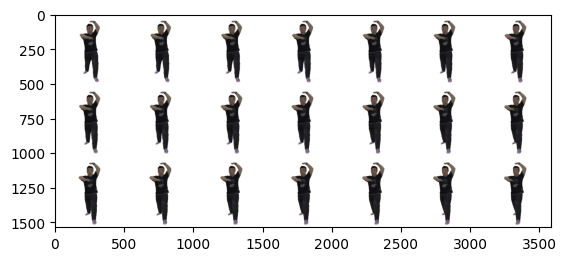

In [13]:
image = np.zeros((512 * 3, 512 * 7, 3)).astype(np.uint8)
for i in range(3):
    for j in range(7):
        idx = i * 3 + j
        image[512 * i:512 * (i + 1), 512 * j:512 * (j + 1), :] = images[idx]

plt.imshow(image)
plt.show()